In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torchmetrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pickle

In [3]:
class EWC_loss(nn.Module):
    def __init__(self, model: nn.Module, information_matrix, lambda_ewc, loss_fn):
        super(EWC_loss, self).__init__()
        for name, param in model.named_parameters():
            self.register_buffer(self.get_orig_name(name), param.detach().clone())
            self.register_buffer(self.get_info_name(name), information_matrix[name])
        
        self.lambda_ewc = lambda_ewc
        self.loss_fn = loss_fn

    def get_orig_name(self, name):
        return f"orig_{name.replace('.', '_')}"
    
    def get_info_name(self, name):
        return f"info_{name.replace('.', '_')}"
    
    def forward(self, model, pred, target):
        # Compute the loss
        loss = self.loss_fn(pred, target)
        buffer = self.state_dict()
        
        # Compute the EWC penalty
        ewc_penalty = 0
        for name, param in model.named_parameters():
            old_param = buffer[self.get_orig_name(name)]
            information = buffer[self.get_info_name(name)]
            ewc_penalty += (information * (param - old_param) ** 2).sum()    
        # Combine the loss and the EWC penalty
        total_loss = loss + self.lambda_ewc * ewc_penalty
        
        return total_loss

In [4]:
class PermutedMNIST(Dataset):
    def __init__(self, base_dataset, permutation=None):
        self.base_dataset = base_dataset
        self.permutation = permutation
        self.targets = base_dataset.targets

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        if self.permutation is not None:
            # Flatten, permute, then reshape back to [1, 28, 28]
            image = image.view(-1)[self.permutation].view(1, 28, 28)
        return image, label

In [5]:
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

perm = np.random.permutation(28 * 28)
task1_dataset = PermutedMNIST(dataset, permutation=None)
task2_dataset = PermutedMNIST(dataset, permutation=perm)
task1_test_dataset = PermutedMNIST(test_dataset, permutation=None)
task2_test_dataset = PermutedMNIST(test_dataset, permutation=perm)

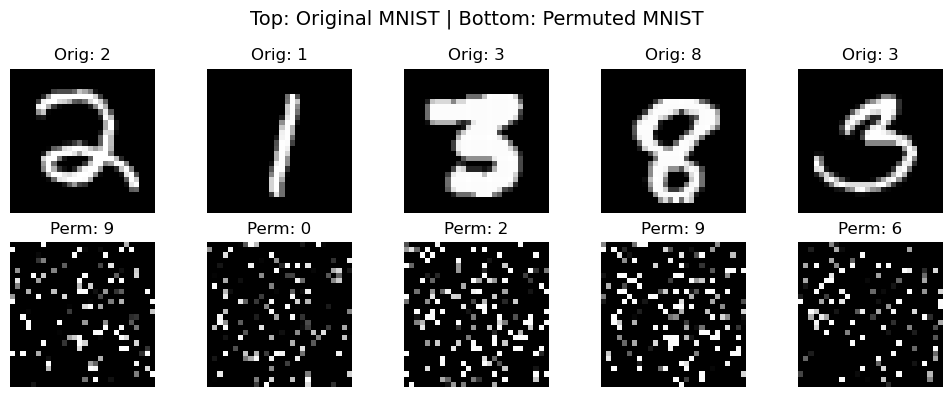

In [6]:
import matplotlib.pyplot as plt
import torchvision

def show_task_examples_from_dataloaders(task1_loader, task2_loader, n=5):
    # Get the first batch from each DataLoader
    task1_batch = next(iter(task1_loader))
    task2_batch = next(iter(task2_loader))

    images1, labels1 = task1_batch
    images2, labels2 = task2_batch

    plt.figure(figsize=(2 * n, 4))

    for i in range(n):
        # Task 1: Original
        plt.subplot(2, n, i + 1)
        plt.imshow(images1[i].squeeze(0), cmap='gray')
        plt.title(f"Orig: {labels1[i].item()}")
        plt.axis('off')

        # Task 2: Permuted
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(images2[i].squeeze(0), cmap='gray')
        plt.title(f"Perm: {labels2[i].item()}")
        plt.axis('off')

    plt.suptitle("Top: Original MNIST | Bottom: Permuted MNIST", fontsize=14)
    plt.tight_layout()
    plt.show()


task1_loader = DataLoader(task1_test_dataset, batch_size=64, shuffle=True)
task2_loader = DataLoader(task2_test_dataset, batch_size=64, shuffle=True)
show_task_examples_from_dataloaders(task1_loader, task2_loader, n=5)


In [7]:
class FLNet(nn.Sequential):
    def __init__(self):
        super(FLNet, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

test_model = FLNet()
model_parameters = filter(lambda p: p.requires_grad, test_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the model: {params}")

Number of parameters in the model: 1663370


In [8]:
def compute_accuracy(model, dataloader, device=None):
    if device is None:
        device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device_ = device
        
    model.to(device_)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device_), labels.to(device_)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if device is None:
        model.cpu()

    return correct / total

def compute_dataloaders_accuracy(model, dataloaders):
    accuracies = []
    for idx, dataloader in enumerate(dataloaders):
        accuracy = compute_accuracy(model, dataloader)
        accuracies.append(accuracy)
    return accuracies

# create validation routine
def validate(model, dataloaders, num_classes, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    # create metric objects
    tm_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average= 'macro', top_k=1)
    tm_con = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes)
    # move metric to device
    model.to(device)
    tm_acc.to(device)
    tm_con.to(device)
    # set network in eval mode
    model.eval()
    # at the end of epoch, validate model
    for loader_idx, loader in enumerate(dataloaders):
        for inputs, targets in loader:
        
            inputs = inputs.to(device)
            targets = targets.to(device)
            # remove singleton dimension
            targets = targets.squeeze()
            # get output
            with torch.no_grad():
                # perform prediction
                logits = model(inputs)
            # update metrics
            _, predicted = torch.max(logits.data, 1)
            tm_acc.update(predicted, targets)
            tm_con.update(predicted, targets)

    # at the end, compute metric
    acc = tm_acc.compute()
    con = tm_con.compute()
    # set network in training mode
    
    return acc, con


def plot_confusion_matrix(conf_mat):
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(conf_mat.cpu())
    x=x.style.background_gradient(cmap=cm)
    display(x)

In [9]:
def trainer(model, loss_fn, dataloader, epochs):
    torch.cuda.empty_cache()
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    #device = "cpu"
    model.to(device)

    for epoch in range(epochs):
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Evaluate on test set
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
        
    return model

def trainer_ewc(model, loss_fn, dataloader, epochs):
    torch.cuda.empty_cache()
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    #device = "cpu"
    model.to(device)
    loss_fn.to(device)

    for epoch in range(epochs):
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = loss_fn(model, preds, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Evaluate on test set
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
        
    return model

In [10]:
def get_normalized_avg_information(informations):
    normalized_info = {name : torch.zeros_like(param) for name, param in informations[0].items()}
    total_num_params = sum([param.numel() for name, param in informations[0].items()])
    for information in informations:
        for name, param in information.items():
            normalized_info[name] += param
    for name, param in normalized_info.items():
        info = normalized_info[name]
        info = info / len(informations)
        info = torch.exp(info) / torch.sum(torch.exp(info))
        info = info * info.numel() / total_num_params
        normalized_info[name] = info
    
    return normalized_info

In [11]:
from fisherunlearn import compute_informations
from fisherunlearn.clients_utils import split_dataset_by_class_distribution

# Model
model = FLNet()
model_naive = FLNet()
model_benchmark = FLNet()
loss_fn = nn.CrossEntropyLoss()

task1_dataloader = DataLoader(task1_dataset, batch_size=64, shuffle=True)
task2_dataloader = DataLoader(task2_dataset, batch_size=64, shuffle=True)
task1_test_dataloader = DataLoader(task1_test_dataset, batch_size=64, shuffle=False)
task2_test_dataloader = DataLoader(task2_test_dataset, batch_size=64, shuffle=False)
classes_datasets = split_dataset_by_class_distribution(task1_dataset, np.identity(10))
classes_dataloaders = [DataLoader(dataset, batch_size=64, shuffle=False) for dataset in classes_datasets]

full_dataset = torch.utils.data.ConcatDataset([task1_dataset, task2_dataset])
full_dataloader = DataLoader(full_dataset, batch_size=64, shuffle=True)


model = trainer(model, loss_fn, task1_dataloader, epochs=5)
model_naive.load_state_dict(model.state_dict())

print(f"Task 1 accuracy after Task 1 training: {compute_accuracy(model, task1_test_dataloader):.4f}")
print(f"Task 2 accuracy after Task 1 training: {compute_accuracy(model, task2_test_dataloader):.4f}")

model_naive = trainer(model_naive, loss_fn, task2_dataloader, epochs=5)
model_benchmark = trainer(model_benchmark, loss_fn, full_dataloader, epochs=5)

# Compute the Fisher information matrix
informations = compute_informations(model, loss_fn, classes_dataloaders)

cuda
Epoch 1/5, Loss: 0.0199
Epoch 2/5, Loss: 0.0039
Epoch 3/5, Loss: 0.2811
Epoch 4/5, Loss: 0.0005
Epoch 5/5, Loss: 0.0014
Task 1 accuracy after Task 1 training: 0.9919
Task 2 accuracy after Task 1 training: 0.1372
cuda
Epoch 1/5, Loss: 0.0801
Epoch 2/5, Loss: 0.1804
Epoch 3/5, Loss: 0.0012
Epoch 4/5, Loss: 0.0014
Epoch 5/5, Loss: 0.0005
cuda
Epoch 1/5, Loss: 0.0654
Epoch 2/5, Loss: 0.0148
Epoch 3/5, Loss: 0.0244
Epoch 4/5, Loss: 0.0577
Epoch 5/5, Loss: 0.0097


Computing clients information:   0%|          | 0/850 [00:00<?, ?batch/s]

In [14]:
model_ewc = FLNet()
model_ewc.load_state_dict(model.state_dict())
info_params = get_normalized_avg_information(informations)

# Train the models on task 2
ewc_loss_fn = EWC_loss(model_ewc, info_params, lambda_ewc=400, loss_fn=loss_fn)
model_ewc = trainer_ewc(model_ewc, ewc_loss_fn, task2_dataloader, epochs=5)

cuda
Epoch 1/5, Loss: 0.3467
Epoch 2/5, Loss: 0.1528
Epoch 3/5, Loss: 0.2361
Epoch 4/5, Loss: 0.2292
Epoch 5/5, Loss: 0.1407


In [13]:
from fisherunlearn import compute_informations
clients_fishers = compute_informations(model, loss_fn, classes_dataloaders, use_FIM=True)
total_fisher = {name: sum([fisher[name] for fisher in clients_fishers]) for name in clients_fishers[0].keys()}

model_ewc_fisher = FLNet()
model_ewc_fisher.load_state_dict(model.state_dict())
info_params_fisher = get_normalized_avg_information([total_fisher])

# Train the models on task 2
ewc_loss_fn_fisher = EWC_loss(model_ewc_fisher, info_params_fisher, lambda_ewc=400, loss_fn=loss_fn)
model_ewc_fisher = trainer_ewc(model_ewc_fisher, ewc_loss_fn_fisher, task2_dataloader, epochs=5)

Computing clients information:   0%|          | 0/850 [00:00<?, ?batch/s]

cuda
Epoch 1/5, Loss: 0.1333
Epoch 2/5, Loss: 0.2766
Epoch 3/5, Loss: 0.3248
Epoch 4/5, Loss: 0.2126
Epoch 5/5, Loss: 0.3324


In [15]:
# Evaluate the models
print(f"Task 1 ewc model accuracy: {compute_accuracy(model_ewc, task1_test_dataloader):.4f}")
print(f"Task 1 ewc fisher model accuracy: {compute_accuracy(model_ewc_fisher, task1_test_dataloader):.4f}")
print(f"Task 1 naive model accuracy: {compute_accuracy(model_naive, task1_test_dataloader):.4f}")
print(f"Task 1 benchmark model accuracy: {compute_accuracy(model_benchmark, task1_test_dataloader):.4f}")
print()
print(f"Task 2 ewc model accuracy: {compute_accuracy(model_ewc, task2_test_dataloader):.4f}")
print(f"Task 2 ewc fisher model accuracy: {compute_accuracy(model_ewc_fisher, task2_test_dataloader):.4f}")
print(f"Task 2 naive model accuracy: {compute_accuracy(model_naive, task2_test_dataloader):.4f}")
print(f"Task 2 benchmark model accuracy: {compute_accuracy(model_benchmark, task2_test_dataloader):.4f}")

Task 1 ewc model accuracy: 0.9343
Task 1 ewc fisher model accuracy: 0.9492
Task 1 naive model accuracy: 0.5542
Task 1 benchmark model accuracy: 0.9884

Task 2 ewc model accuracy: 0.9592
Task 2 ewc fisher model accuracy: 0.9589
Task 2 naive model accuracy: 0.9714
Task 2 benchmark model accuracy: 0.9689
